# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

In [2]:
sns.set_theme(style='darkgrid')

# 2. Load Data

In [3]:
test = pd.read_csv('df_pred.csv')

# 3. Preprocessing

In [4]:
test_ids = test['SK_ID_CURR']
prediction = test['Prediction']
labels = test['TARGET']
test = test.drop(columns=['SK_ID_CURR', 'TARGET', 'Prediction'])

In [5]:
categorical_features_1 = []
categorical_features_2 = []

for col in test.select_dtypes(['object', 'bool']):
    if len(list(test[col].unique())) <= 2:
        categorical_features_1.append(col)
    else:
        categorical_features_2.append(col)

In [6]:
numerical_features = test.select_dtypes(['float64', 'int64']).columns.tolist()

In [7]:
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler(feature_range=(0, 1)))
categorical_pipeline_1 = make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OrdinalEncoder())
categorical_pipeline_2 = make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OneHotEncoder(handle_unknown='ignore'))

In [8]:
preprocessor = make_column_transformer((numerical_pipeline, numerical_features), (categorical_pipeline_1, categorical_features_1), (categorical_pipeline_2, categorical_features_2))

# 4. Functions

In [9]:
def get_column_names_from_ColumnTransformer(column_transformer):
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1], Pipeline):
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        if isinstance(transformer, OneHotEncoder):
            if isinstance(raw_col_name, str):
                names = transformer.get_feature_names(input_features=[raw_col_name])
            else:
                names = transformer.get_feature_names(input_features=raw_col_name)
        elif isinstance(transformer, PolynomialFeatures):
            names = transformer.get_feature_names(input_features=raw_col_name)
        else:
            try:
                names = transformer.get_feature_names()
            except AttributeError:
                # if no 'get_feature_names' function, use raw column name
                names = raw_col_name
        if isinstance(names, np.ndarray):  # eg.
            col_name += names.tolist()
        elif isinstance(names, list):
            col_name += names
        elif isinstance(names, str):
            col_name.append(names)
    return col_name

In [10]:
def pred_prob(df, column, threshold):
    df['Result'] = np.where(df[column] >= threshold, 1, 0)
    return df

In [11]:
def conf_matrix(y_test, pred):
    con_mat = confusion_matrix(y_test, pred)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
    plt.figure(figsize=(4, 4))
    plt.title('Confusion Matrix', size=15)
    sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

In [12]:
def plot_distribution_tn_fp(features):
    for i in features:
        plt.figure(figsize=(10, 6))
        plt.title("Distribution of %s" % i)
        sns.kdeplot(true_negative[i].dropna(), color='blue', label='True Negative')
        sns.kdeplot(false_positive[i].dropna(), color='red', label='False Positive')
        plt.legend()
        plt.show()

In [13]:
def plot_distribution_tp_fp(feature):
    for i in features:
        plt.figure(figsize=(10, 6))
        plt.title("Distribution of %s" % i)
        sns.kdeplot(false_positive[i].dropna(), color='red', label='False Positive')
        sns.kdeplot(true_positive[i].dropna(), color='green', label='True Positive')
        plt.legend()
        plt.show()

In [14]:
def plot_distribution_y_m(feature):
    plt.figure(figsize=(10, 6))
    plt.title("Distribution of %s" % feature)
    sns.kdeplot(false_positive_y_m[feature].dropna(), color='red', label='False Positive')
    sns.kdeplot(true_positive_y_m[feature].dropna(), color='green', label='True Positive')
    plt.legend()
    plt.show()

# 5. Analyze

In [15]:
X = preprocessor.fit_transform(test)
X = pd.DataFrame(X, columns=get_column_names_from_ColumnTransformer(preprocessor))

In [16]:
X['Prediction'] = prediction
X['TARGET'] = labels
X['SK_ID_CURR'] = test_ids

## 5.1. Precision, Recall, AUC

In [17]:
x = np.arange(0.1, 0.95, 0.05)
auc_res = []
precision_res = []
recall_res = []
for i in x:
    res = pred_prob(X, 'Prediction', i)
    auc_res.append(roc_auc_score(X['TARGET'], res['Result']))
    precision_res.append(precision_score(X['TARGET'], res['Result']))
    recall_res.append(recall_score(X['TARGET'], res['Result']))

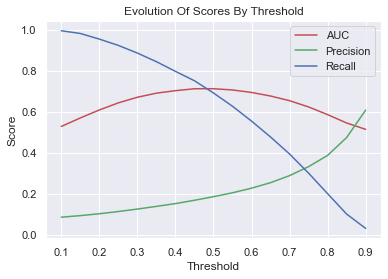

In [18]:
plt.plot(x, auc_res, color='r', label='AUC')
plt.plot(x, precision_res, color='g', label='Precision')
plt.plot(x, recall_res, color='b', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title("Evolution Of Scores By Threshold")
plt.legend()

In [19]:
X = pred_prob(X, 'Prediction', 0.5)

We can see that recall and precision have an opposite evolution.
Wanting to increase recall would decrease precision and vice versa.

AUC is highest around the 0.5 threshold.

## 5.2. True Negative vs False Positive

In [20]:
X['TARGET'] = X['TARGET'].astype(int)

In [21]:
true_negative = X[X['Result'] == 0]
true_negative = true_negative[true_negative['TARGET'] == 0]

In [22]:
false_positive = X[X['Result'] == 1]
false_positive = false_positive[false_positive['TARGET'] == 0]

In [23]:
features = ['CREDIT_TERM',
            'EXT_SOURCE_1',
            'EXT_SOURCE_2',
            'EXT_SOURCE_3',
            'client_installments_AMT_PAYMENT_min_sum',
            'AMT_ANNUITY',
            'DAYS_BIRTH',
            'bureau_DAYS_CREDIT_max',
            'client_cash_CNT_INSTALMENT_FUTURE_mean_max',
            'AMT_GOODS_PRICE',
            'AMT_CREDIT',
            'DAYS_EMPLOYED',
            'bureau_DAYS_CREDIT_ENDDATE_max',
            'bureau_DAYS_ENDDATE_FACT_max',
            'bureau_AMT_CREDIT_SUM_DEBT_mean',
            'DAYS_ID_PUBLISH',
            'CODE_GENDER_F',
            'previous_NAME_CONTRACT_STATUS_Refused_mean',
            'ANNUITY_INCOME_PERCENT',
            'client_installments_AMT_PAYMENT_min_min'
           ]

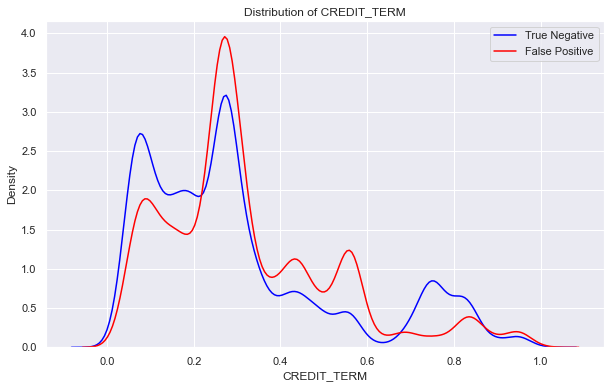

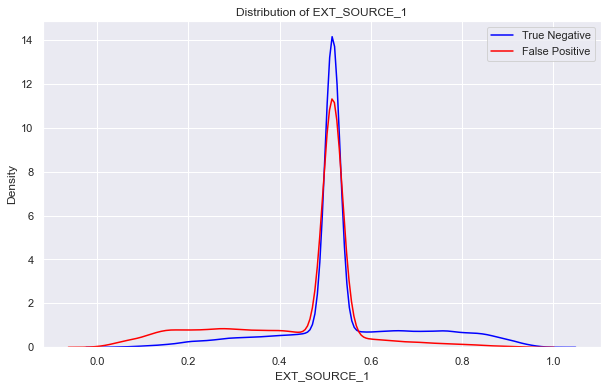

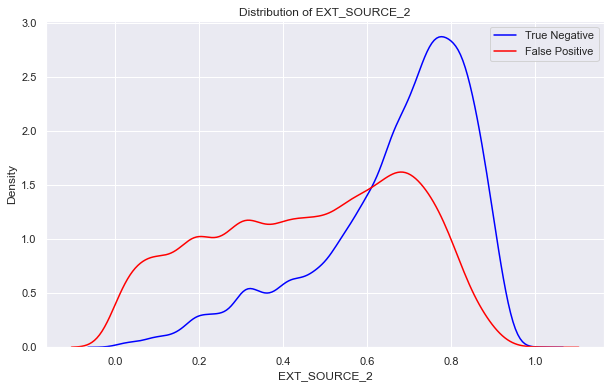

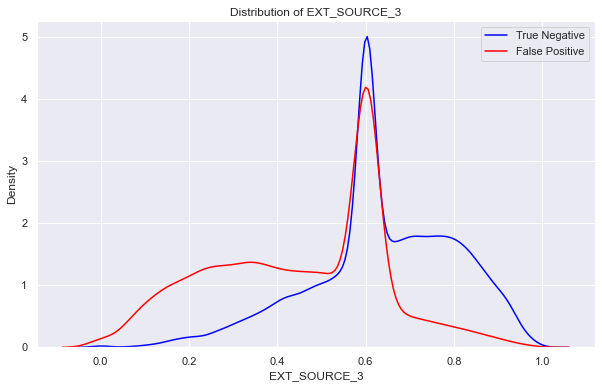

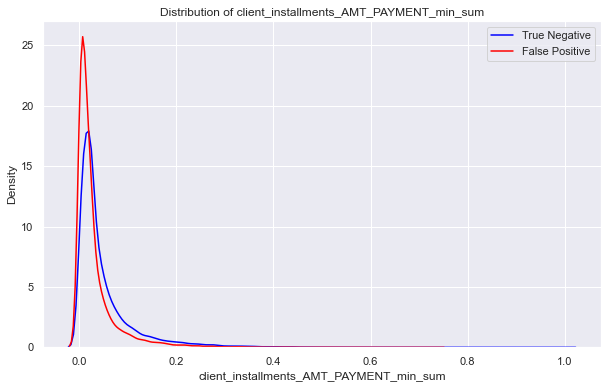

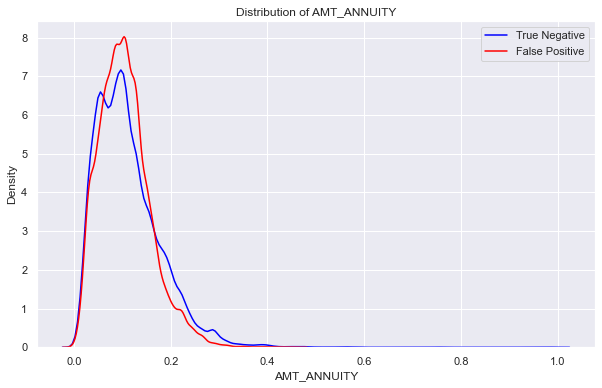

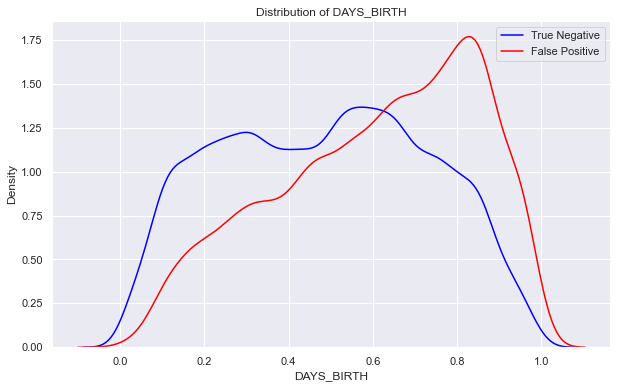

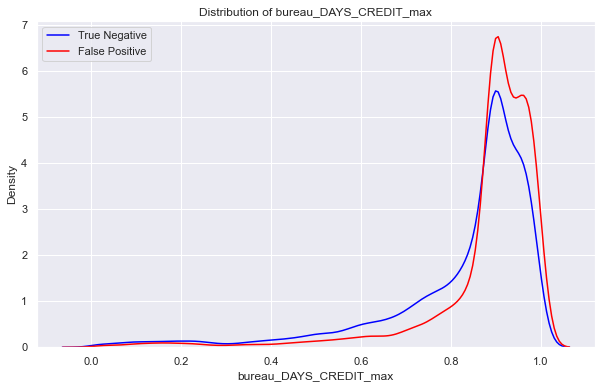

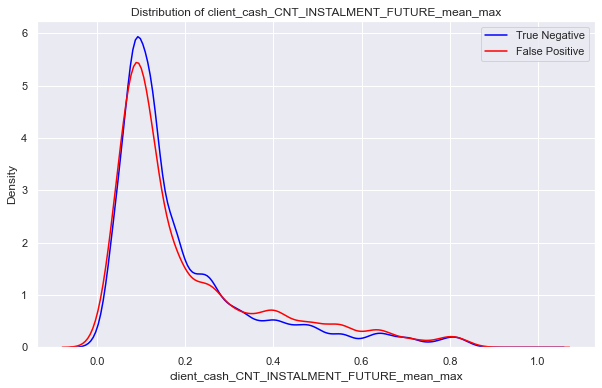

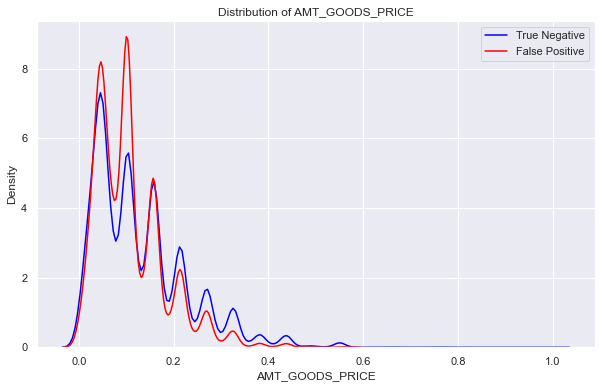

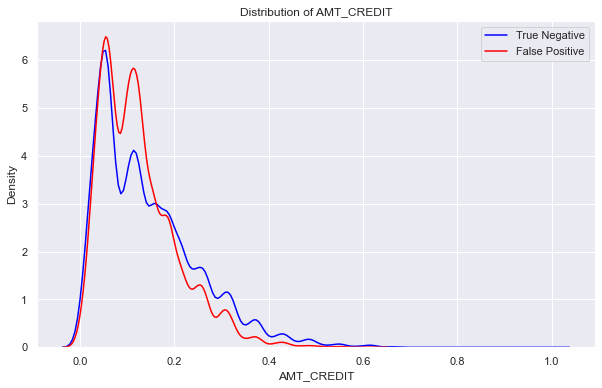

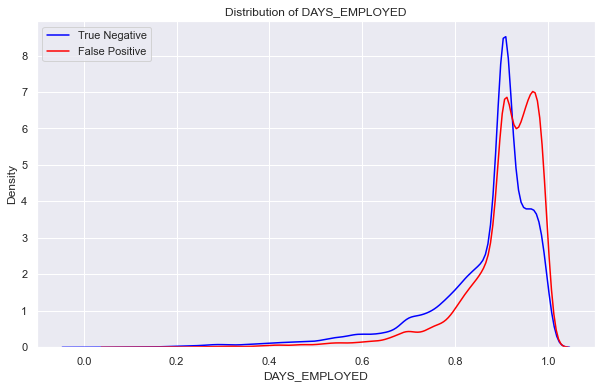

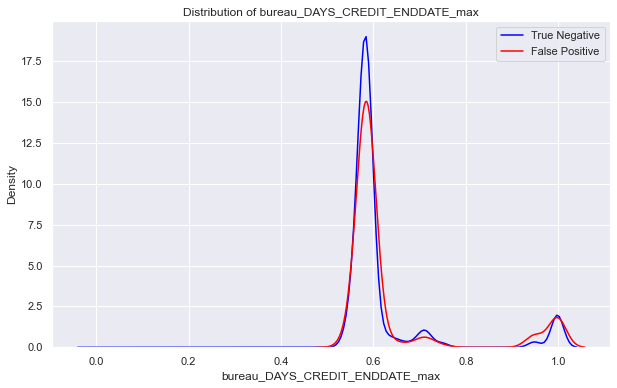

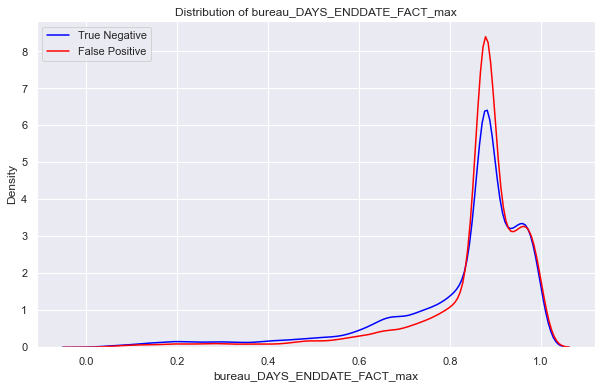

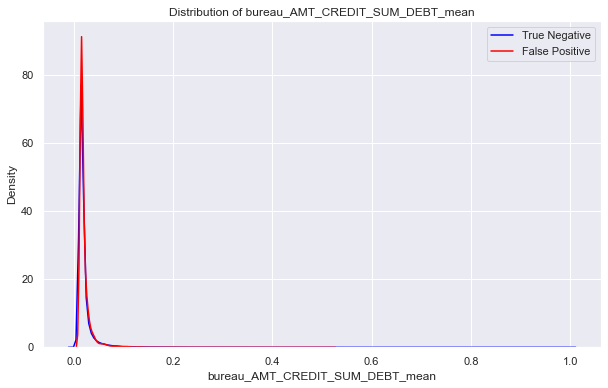

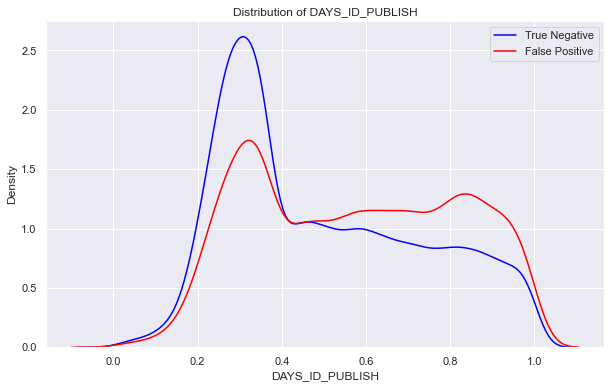

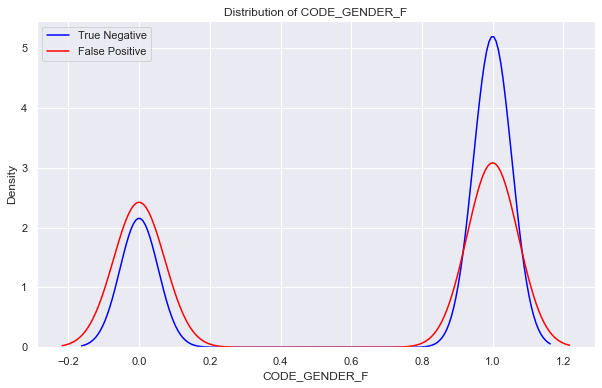

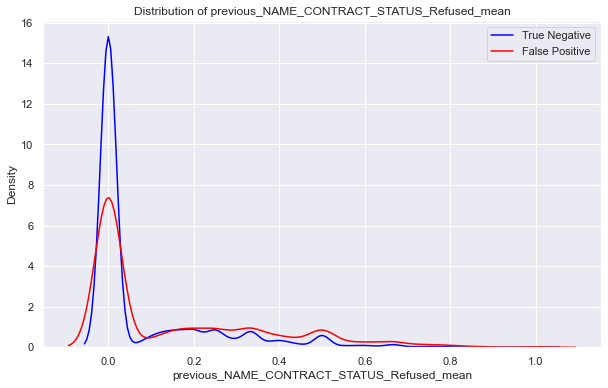

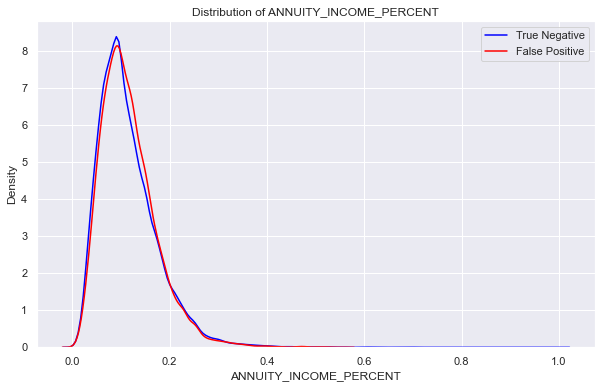

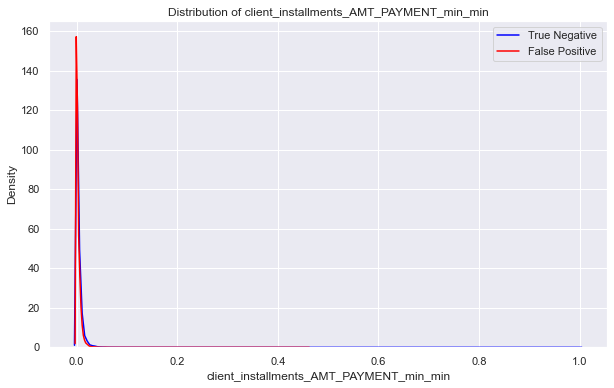

In [24]:
plot_distribution_tn_fp(features)

Why have some creditworthy clients been classified as non-creditworthy ?

To answer this question, we studied the density of true negatives and false positives.

We can notice differences for variables EXT_SOURCE_2, EXT_SOURCE_3, BIRTH_DAYS (young people tend to be classified as non-creditworthy), CODE_GENDER_F (men tend to be classified as non-creditworthy).

## 5.3. Improve Precision

In [25]:
true_positive = X[X['Result'] == 1]
true_positive = true_positive[true_positive['TARGET'] == 1]

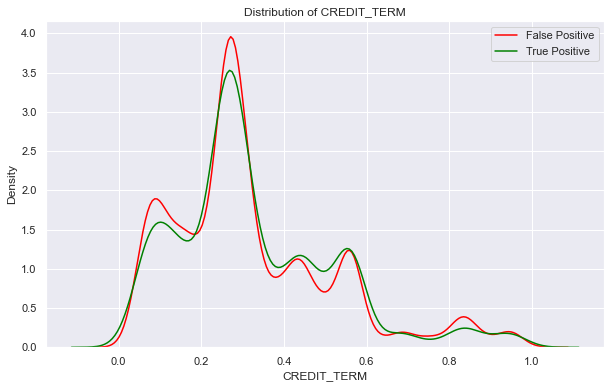

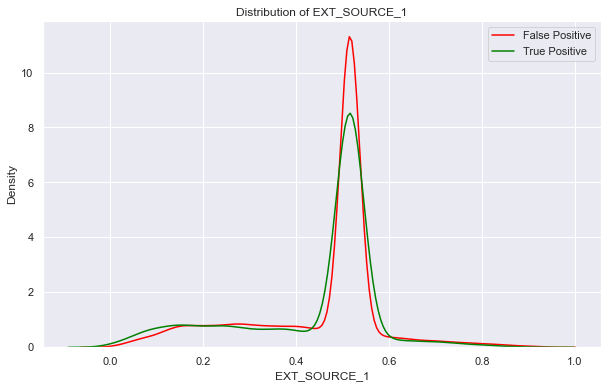

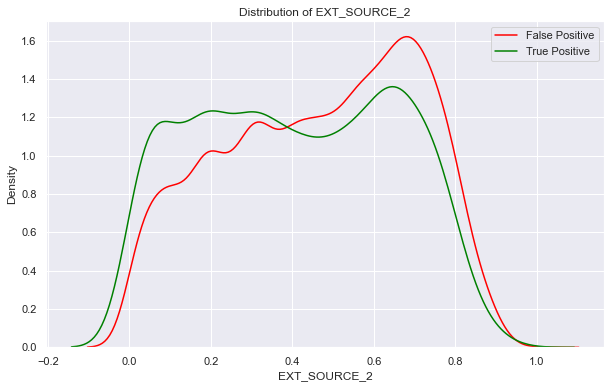

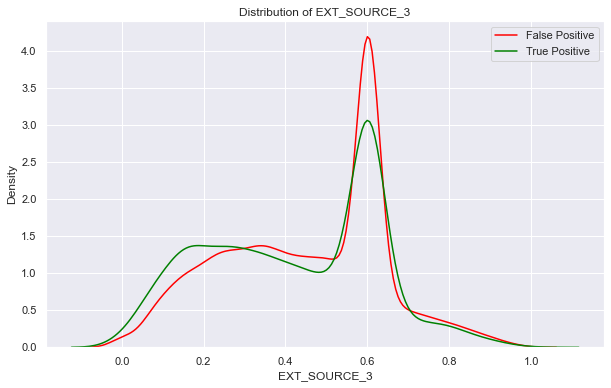

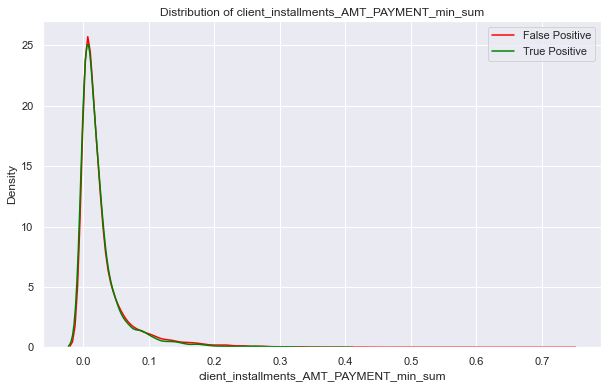

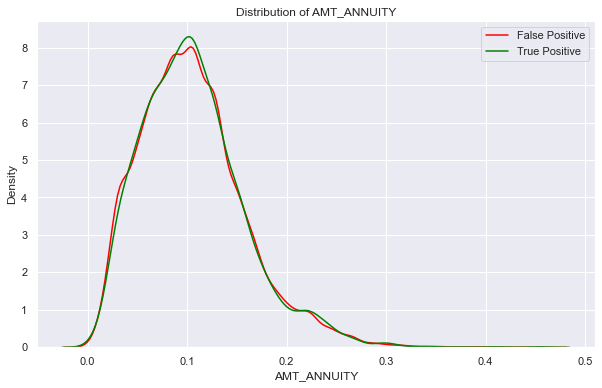

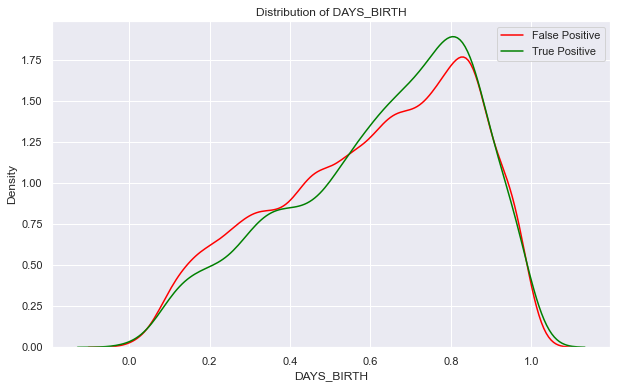

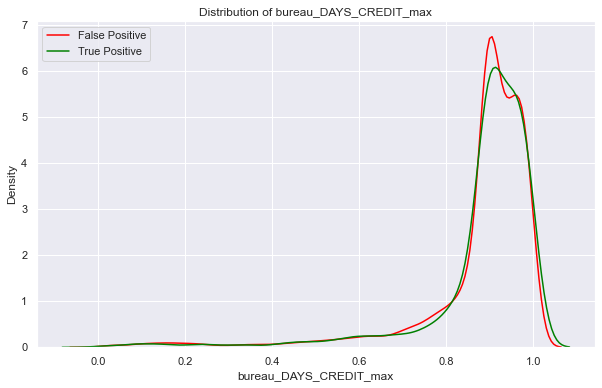

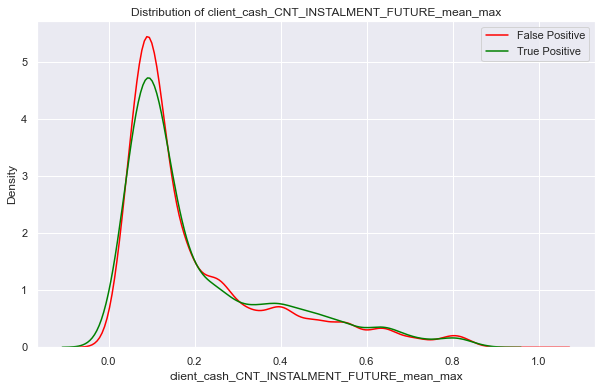

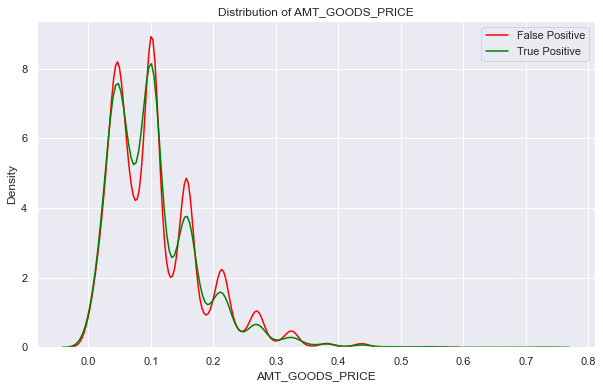

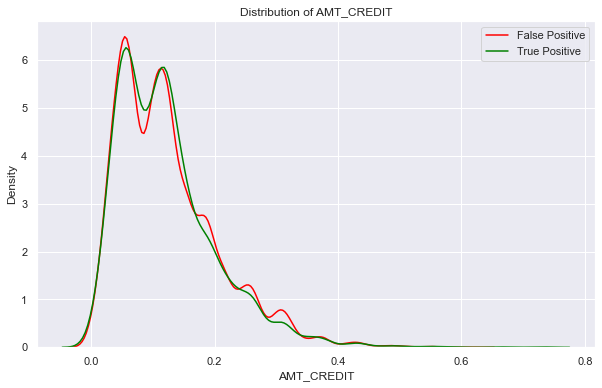

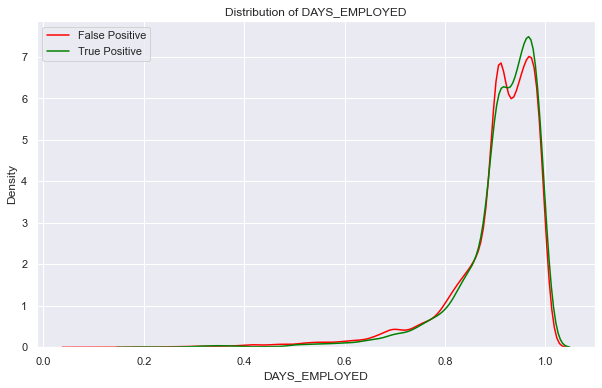

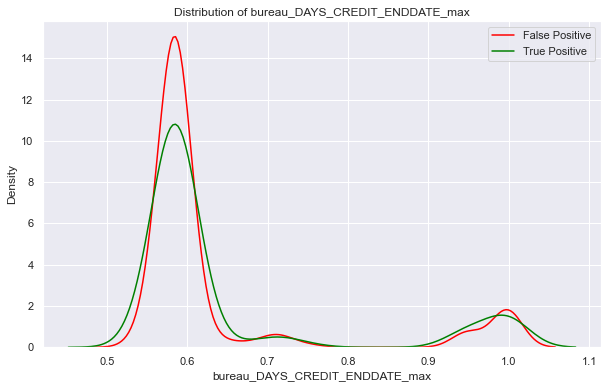

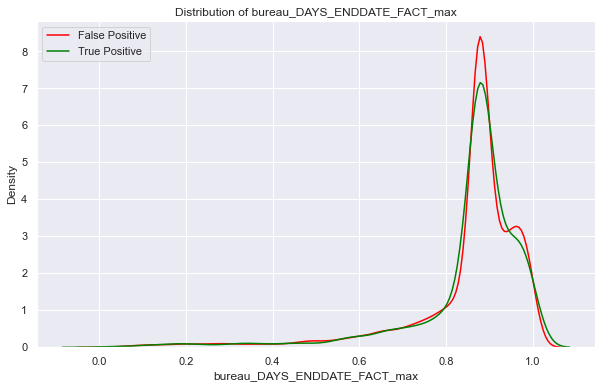

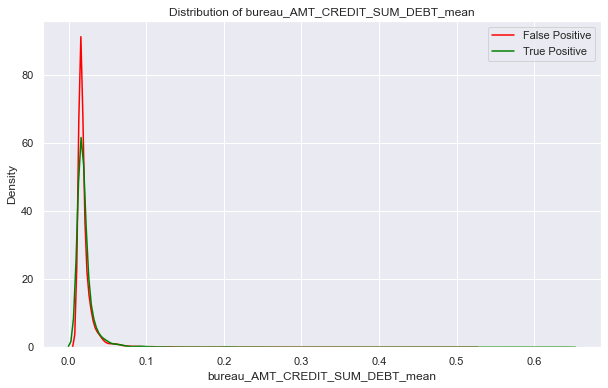

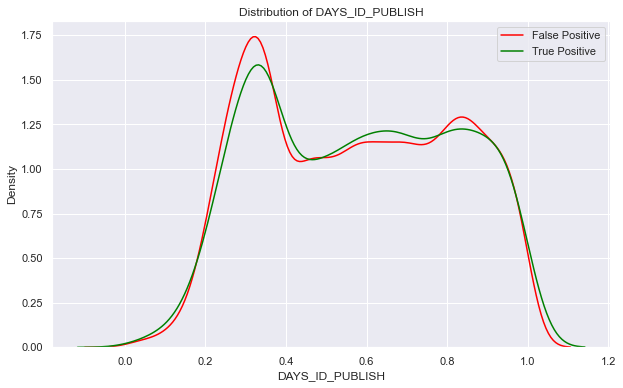

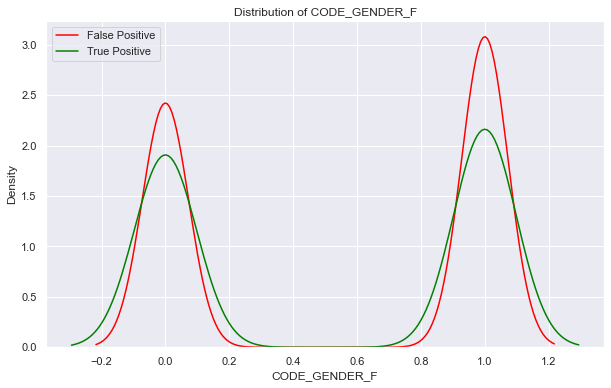

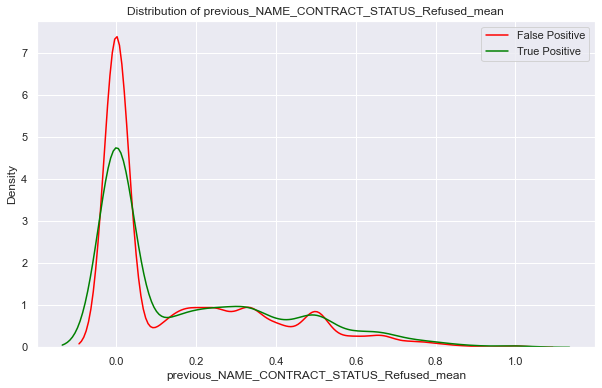

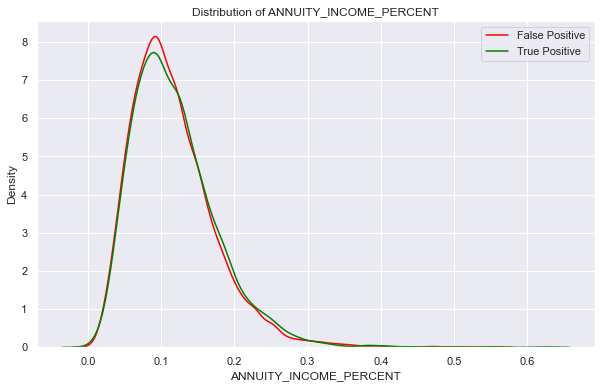

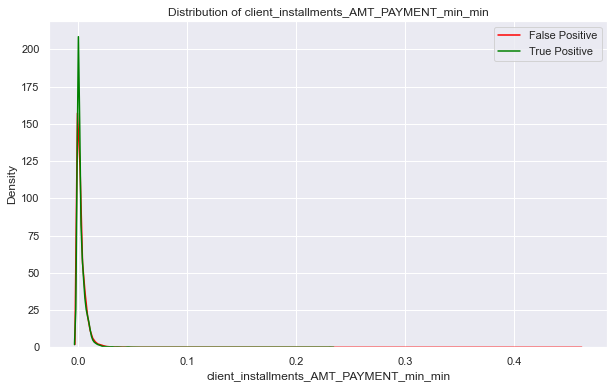

In [26]:
plot_distribution_tp_fp(features)

Is it possible to differentiate between creditworthy clients classifying as non-creditworthy and non-creditworthy clients ?

To answer this question, we studied the density of false positives and true positives.

We can see a slight difference with EXT_SOURCE_2, but beside this we do not see any real difference between these 2 groups.

#### Young Men

In this part, I tried to improve the precision score without lowering the recall.

It didn't work.

In [27]:
false_positive_y = false_positive[false_positive['DAYS_BIRTH'] >= 0.6]
true_positive_y = true_positive[true_positive['DAYS_BIRTH'] >= 0.6]

In [28]:
false_positive_y_m = false_positive_y[false_positive_y['CODE_GENDER_M'] == 1]
true_positive_y_m = true_positive_y[true_positive_y['CODE_GENDER_M'] == 1]

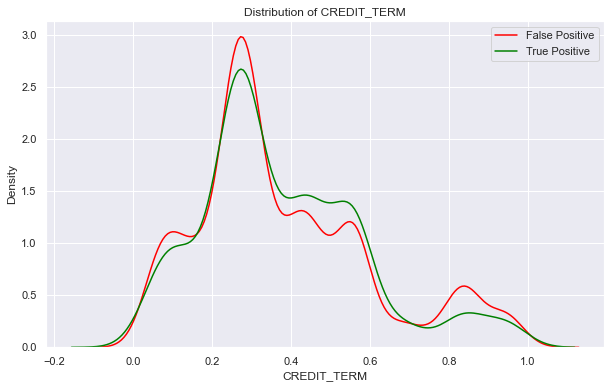

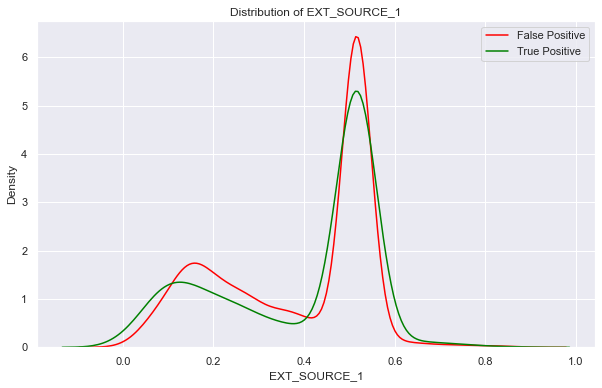

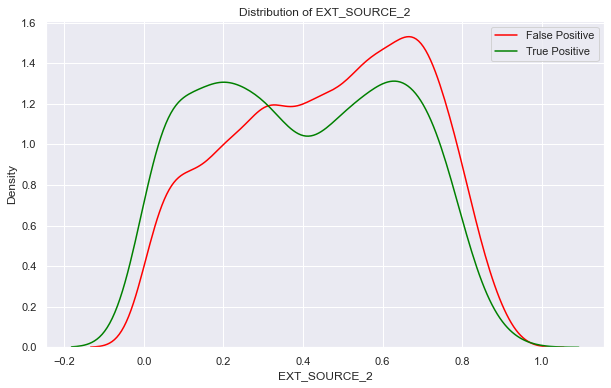

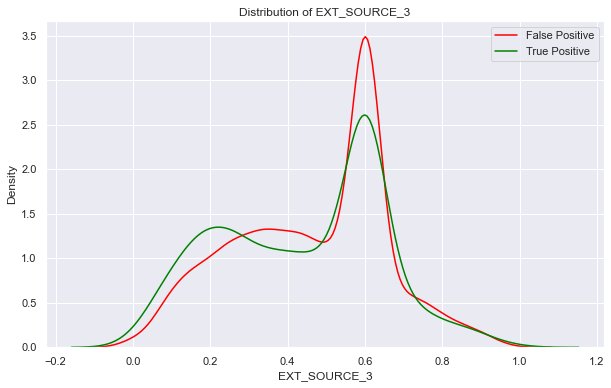

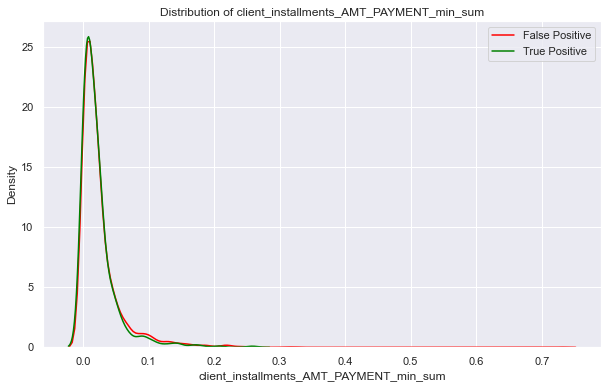

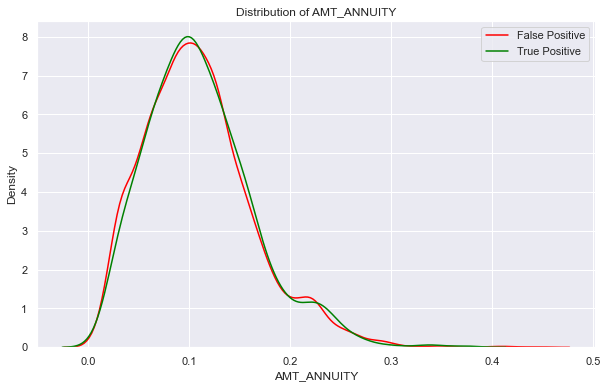

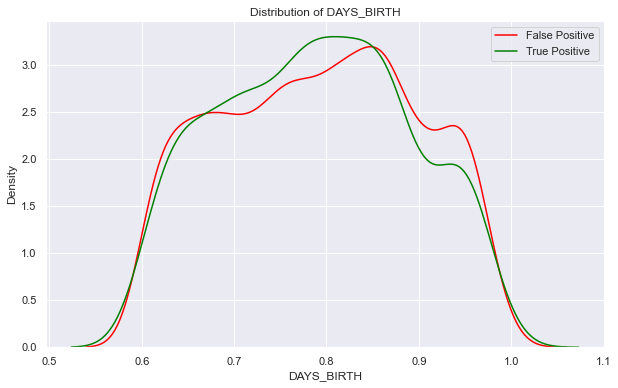

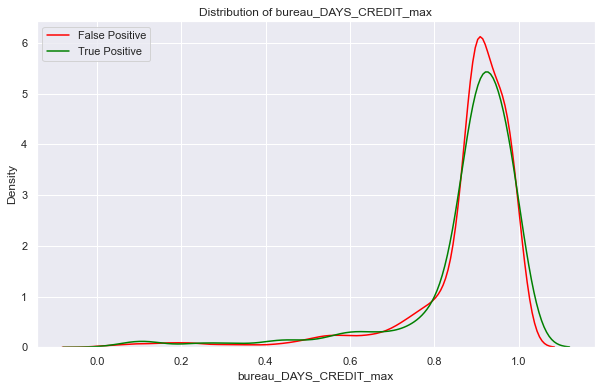

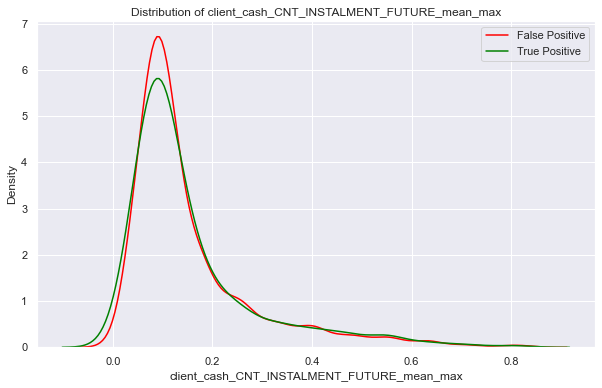

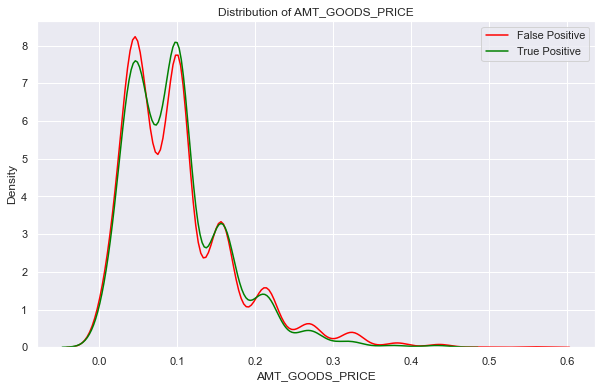

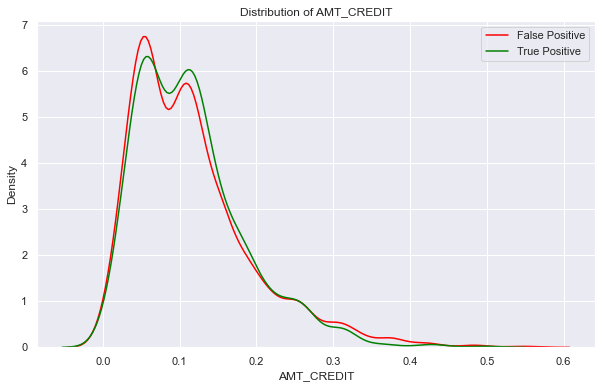

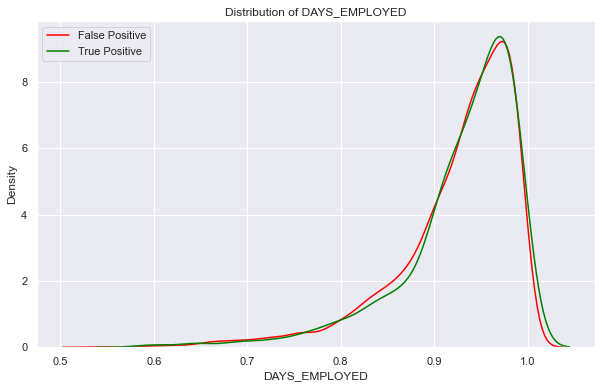

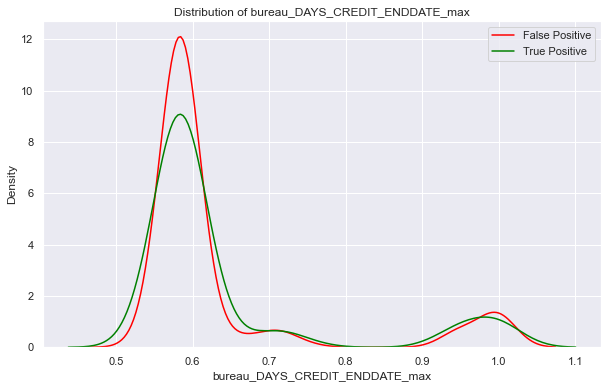

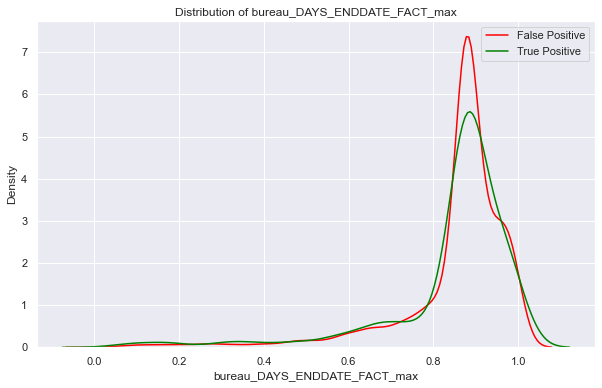

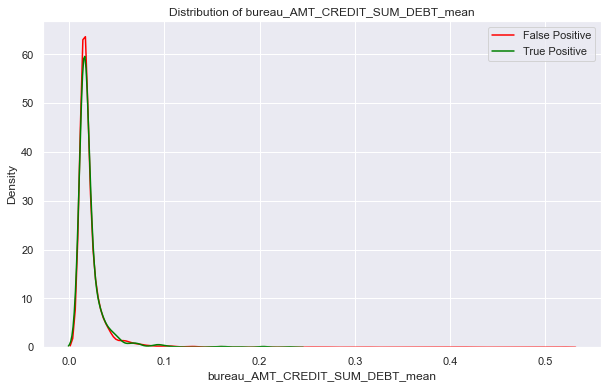

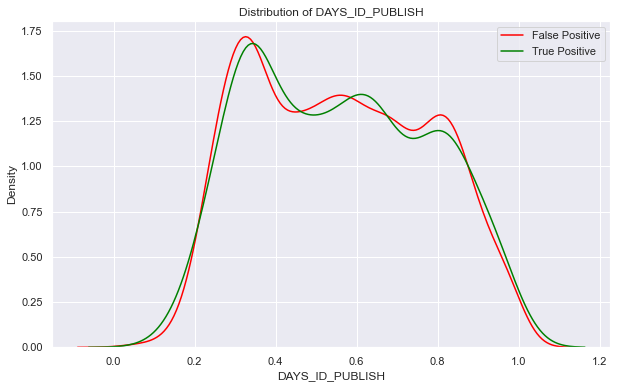

No handles with labels found to put in legend.


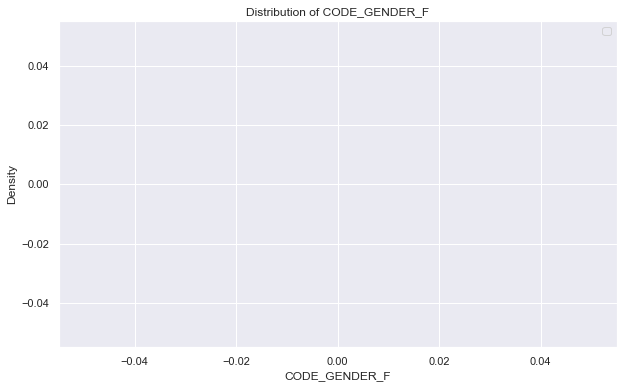

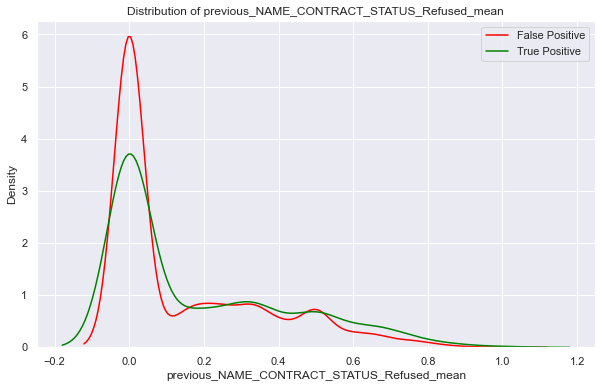

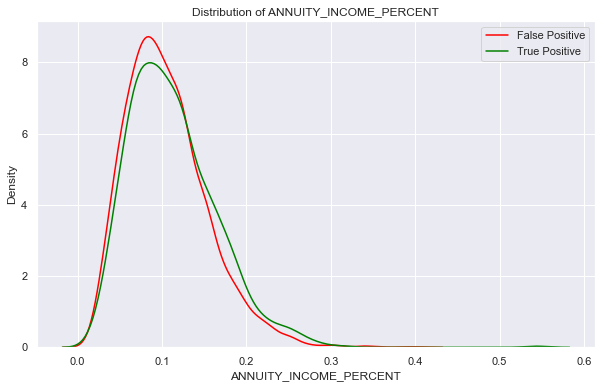

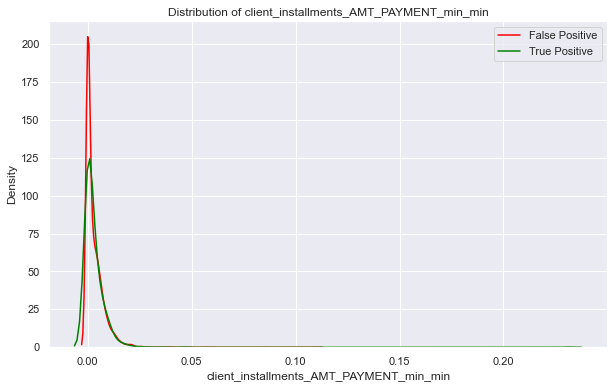

In [29]:
for i in features:
    plot_distribution_y_m(i)

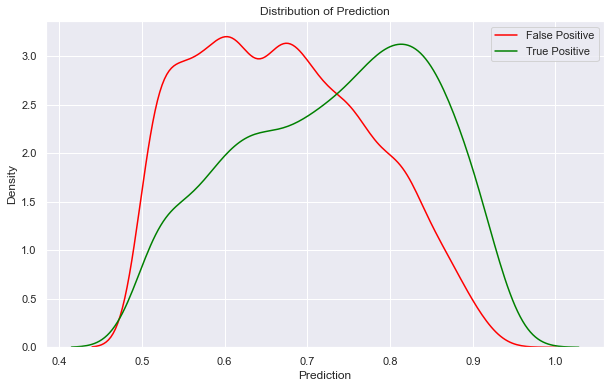

In [30]:
plot_distribution_y_m('Prediction')

In [31]:
Y = X[X['DAYS_BIRTH'] >= 0.6]
Y = Y[Y['CODE_GENDER_M'] == 1]

In [32]:
def pred_change_best(df, df_2):
    prediction = [0.51, 0.55, 0.6, 0.65, 0.7]
    ext_source = [0, 0.4, 0.6]
    auc = []
    precision = []
    recall = []
    params = []
    nb_row = []
    for i in prediction:
        for k in ext_source:
            df_c = df.copy()
            df_y_m = df_2.copy()
            df_c.loc[df_c['NAME_EDUCATION_TYPE_Academic degree'] == 1, 'Result'] = 0
            df_y_m = df_y_m[df_y_m['Result'] == 1]
            df_y_m = df_y_m[df_y_m['Prediction'] < i]
            df_y_m = df_y_m[df_y_m['EXT_SOURCE_2'] > k]
            index = df_y_m['SK_ID_CURR']
            df_c.loc[df_c['SK_ID_CURR'].isin(index), 'Result'] = 0
            auc.append(roc_auc_score(df_c['TARGET'], df_c['Result']))
            precision.append(precision_score(df_c['TARGET'], df_c['Result']))
            recall.append(recall_score(df_c['TARGET'], df_c['Result']))
            params.append(['Prediction =', i, 'EXT_SOURCE_2 =', k])
            nb_row.append(len(index))
    return auc, precision, recall, params, nb_row

In [33]:
def pred_change(df, df_y_m, prediction, ext_source_2):
    df_c = df.copy()
    df_c.loc[df_c['NAME_EDUCATION_TYPE_Academic degree'] == 1, 'Result'] = 0
    df_y_m = df_y_m[df_y_m['Result'] == 1]
    df_y_m = df_y_m[df_y_m['Prediction'] < prediction]
    df_y_m = df_y_m[df_y_m['EXT_SOURCE_2'] > ext_source_2]
    index = df_y_m['SK_ID_CURR']
    df_c.loc[df_c['SK_ID_CURR'].isin(index), 'Result'] = 0
    return df_c

In [34]:
auc, precision, recall, params, nb = pred_change_best(X, Y)

In [35]:
data = {'AUC': auc, 'Precision': precision, 'Recall': recall, 'Params': params, 'Nb_Client': nb}
df_result = pd.DataFrame(data)

In [36]:
df_result.head(15)

,AUC,Precision,Recall,Params,Nb_Client
0,0.712332,0.185864,0.688624,"[Prediction =, 0.51, EXT_SOURCE_2 =, 0]",151
1,0.712357,0.185750,0.689028,"[Prediction =, 0.51, EXT_SOURCE_2 =, 0.4]",129
2,0.712425,0.185543,0.689836,"[Prediction =, 0.51, EXT_SOURCE_2 =, 0.6]",87
3,0.709999,0.187742,0.675894,"[Prediction =, 0.55, EXT_SOURCE_2 =, 0]",671
4,0.710694,0.187229,0.679531,"[Prediction =, 0.55, EXT_SOURCE_2 =, 0.4]",526
5,0.711226,0.186459,0.683370,"[Prediction =, 0.55, EXT_SOURCE_2 =, 0.6]",350
6,0.706645,0.190198,0.658719,"[Prediction =, 0.6, EXT_SOURCE_2 =, 0]",1348
7,0.708338,0.189082,0.667003,"[Prediction =, 0.6, EXT_SOURCE_2 =, 0.4]",1030
8,0.710151,0.187700,0.676500,"[Prediction =, 0.6, EXT_SOURCE_2 =, 0.6]",651
9,0.701262,0.191863,0.637503,"[Prediction =, 0.65, EXT_SOURCE_2 =, 0]",2044


In [37]:
df_result[df_result['AUC'] == df_result['AUC'].max()]

,AUC,Precision,Recall,Params,Nb_Client
2,0.712425,0.185543,0.689836,"[Prediction =, 0.51, EXT_SOURCE_2 =, 0.6]",87


In [38]:
df_result[df_result['Recall'] == df_result['Recall'].max()]

,AUC,Precision,Recall,Params,Nb_Client
2,0.712425,0.185543,0.689836,"[Prediction =, 0.51, EXT_SOURCE_2 =, 0.6]",87


In [39]:
df_result[df_result['Precision'] == df_result['Precision'].max()]

,AUC,Precision,Recall,Params,Nb_Client
12,0.695265,0.193536,0.61467,"[Prediction =, 0.7, EXT_SOURCE_2 =, 0]",2770


In [40]:
X_c = pred_change(X, Y, prediction=0.7, ext_source_2=0)

In [41]:
print('AUC of X :', roc_auc_score(X['TARGET'], X['Result']))
print('AUC of X_c :', roc_auc_score(X_c['TARGET'], X_c['Result']))
print('Precision of X :', precision_score(X['TARGET'], X['Result']))
print('Precision of X_c :', precision_score(X_c['TARGET'], X_c['Result']))
print('Recall of X :', recall_score(X['TARGET'], X['Result']))
print('Recall of X_c :', recall_score(X_c['TARGET'], X_c['Result']))

AUC of X : 0.7126929786556548
AUC of X_c : 0.6952649349995838
Precision of X : 0.185141126851952
Precision of X_c : 0.1935360732917674
Recall of X : 0.6918569407961205
Recall of X_c : 0.614669630228329


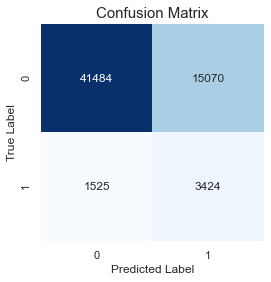

In [42]:
conf_matrix(X['TARGET'], X['Result'])

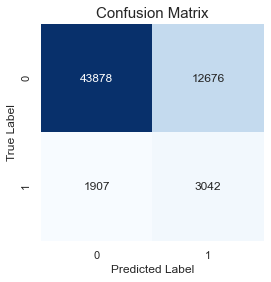

In [43]:
conf_matrix(X_c['TARGET'], X_c['Result'])